# ESM vs WOA Southern Ocean Surface Temperature Comparison

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38293")
client

Client Scheduler: tcp://127.0.0.1:38293 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 25.77 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
maskName = "OceanMaskVolcello2"

<br>

#### Importing Libaries

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data Loading

<b>WOA Data</b>

In [4]:
def WOAOpen(dsLink):
    dsWOA = pd.read_csv(dsLink, skiprows =1,index_col=[0,1])
    dsWOA = dsWOA.rename({' AND VALUES AT DEPTHS (M):0':'0'}, axis='columns')
    dsWOAm = pd.melt(dsWOA,var_name = 'LEVEL', value_name = 'TEMPERATURE', ignore_index = False)
    dsWOAm = dsWOAm.astype({'LEVEL':int})
    dsWOAm = dsWOAm.set_index('LEVEL', append = True)
    dsName = str(dsLink)[6:-4]
    print("WOA data for "+dsName+" successfully loaded and arranged in pd.")
    return dsWOAm

def WOAConvert(dsWOA, name):
    dfWOA = dsWOA.to_xarray()
    dfWOA = dfWOA.rename({'COMMA SEPARATED LATITUDE':'lat', ' LONGITUDE':'lon', 'LEVEL':'lev'})
    dfWOALat = dfWOA.sel(lat=latSel)
    dfWOALat = dfWOALat.to_array()
    dfWOALat = dfWOALat.rename(name)
    print("WOA data for "+ dfWOALat.name+" successfully converted to xr and lat filtered.")
    return dfWOALat

def WOAOpenConv(dsLink):
    dfName = str(dsLink)[6:-4]
    return WOAConvert(WOAOpen(dsLink),dfName)

print("WOA handling functions defined")

WOA handling functions defined


In [5]:
dfWOALatDecav = WOAOpenConv("woa18_decav_t00mn01.csv") #Decadal average
dfWOALatCmean = WOAOpenConv("woa18_A5B7_t00an01.csv") #Climatological mean
dfWOALatSmean = WOAOpenConv("woa18_A5B7_t00mn01.csv") #Statistical mean

WOA data for decav_t00mn01 successfully loaded and arranged in pd.
WOA data for decav_t00mn01 successfully converted to xr and lat filtered.
WOA data for A5B7_t00an01 successfully loaded and arranged in pd.
WOA data for A5B7_t00an01 successfully converted to xr and lat filtered.
WOA data for A5B7_t00mn01 successfully loaded and arranged in pd.
WOA data for A5B7_t00mn01 successfully converted to xr and lat filtered.


<br>
<b>ESM Data</b>

In [6]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq('thetao') & df.experiment_id.eq('historical') & df.source_id.eq('E3SM-1-0')]
dfArea = df[df.variable_id.eq('areacello') & df.source_id.eq('CESM2')]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[1]), consolidated=True)
dataAreaRaw = dsArea.areacello

for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets

dfESMLat = fileSet.thetao.sel(lat=latSel) #Selection of latitude
dfESMLat = dfESMLat.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLat["time"][0].values
globalDateInc = dfESMLat["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLat["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM data sucessfully loaded.")

ESM data sucessfully loaded.


<br>
<b>Mask Import and Loading</b>

In [7]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask imported and loaded")

Mask imported and loaded


<br>

#### Calculations
<b>Functions:</b><br>
<ul>
<li>rangeMeanSurfaceTempESM - 
<li>rangeMeanSurfaceTempWOA - 
</ul>

In [8]:
@delayed
def meanTemp(dataSet, masking):
    '''Calculates and returns Mean Ocean temperature for a given data set.
    Requires global dataAreaSH, totalArea'''
    if masking:
        return (dataSet*dataAreaSHM).sum(dim=['lon', 'lat']) / totalAreaM
    else:
        return (dataSet*dataAreaSH).sum(dim=['lon', 'lat']) / totalArea 

dataAreaSH = dataAreaRaw.sel(lat=latSel) #Selecting data for relevant latittude]
dataAreaSHM = dataAreaSH.where(oceanMask==1)
totalArea = dataAreaSH.sum(dim=['lon', 'lat']) #Summing selected area
totalAreaM = dataAreaSHM.sum(dim=['lon', 'lat'])

#Area = dx x dy, dx=r*dtheta*cos(phi), dy=r*dphi where phi=lat, theta=lon
#Area = dx x dy, 



def rangeMeanSurfaceTempESM(startDate, endDate, mask, runID, plotNo):
    #define data set
    if mask:
        subSet = dfESMLatM.copy()
    else:
        subSet = dfESMLat.copy()
    subSet = subSet.sel(lev=5.0, time=slice(startDate, endDate))
    subSetClean = subSet.reset_coords(drop=True)
    if (runID == "All"):
        subSetMeanR = subSetClean.mean('RunID', keep_attrs = True)
    elif (int(runID) > fileCount):
        runID = "All"
        subSetMeanR = subSetClean.mean('RunID', keep_attrs = True)
    else:
        subSetMeanR = subSetClean.sel(RunID = runID)
    subSetMeanTR = subSetMeanR.mean('time', keep_attrs = True)
    geoTempPlot(subSetMeanTR, str(startDate)+" - "+str(endDate), mask, "ESM3 ("+str(runID)+")", plotNo)
    
    
def rangeMeanSurfaceTempWOA(dfWOASet, mask, plotNo):
    subSet = dfWOASet.copy()
    subSet = subSet.sel(lev=5.0)
    subSetClean = subSet.reset_coords(drop=True)
    geoTempPlot(subSetClean, dfWOASet.name, mask, "WOA", plotNo)

print("Calculation functions defined")

Calculation functions defined


<br>
Maximum and minimum temperatures across all data sets for plotting limits.

In [9]:
dfSurfaceTemp = dfESMLat.copy()
dfSurfaceTemp = dfSurfaceTemp.sel(lev=5.0, time=slice('2005-01', '2014-12'))
dfSurfaceTemp = dfSurfaceTemp.reset_coords(drop=True)
dfSurfaceTemp = dfSurfaceTemp.mean('time', keep_attrs = True)
#dfSurfaceTemp = dfSurfaceTemp.mean('RunID', keep_attrs = True)
surfaceTempMin = dfSurfaceTemp.min() #Sets minimum temperature for all data sets to ESM3 min
surfaceTempMin = surfaceTempMin.compute()
surfaceTempMin = round(float(surfaceTempMin.values),3)
surfaceTempMax = dfSurfaceTemp.max() #Sets minimum temperature for all data sets to ESM3 min
surfaceTempMax = surfaceTempMax.compute()
surfaceTempMax = round(float(surfaceTempMax.values),3)
print("ESM surface temp min = "+str(float(surfaceTempMin)))
print("ESM surface temp max = "+str(float(surfaceTempMax)))

WOADataList = [dfWOALatDecav, dfWOALatCmean, dfWOALatSmean]
for i in WOADataList:
    WOASurfaceData = i.sel(lev=5.0)
    WOASurfaceTempMin = WOASurfaceData.min()
    WOASurfaceTempMin = WOASurfaceTempMin.compute()
    WOASurfaceTempMax = WOASurfaceData.max()
    WOASurfaceTempMax = WOASurfaceTempMax.compute()
    print("WOA "+i.name+" surface temp min = "+str(WOASurfaceTempMin.values))
    print("WOA "+i.name+" surface temp max = "+str(WOASurfaceTempMax.values))
    if float(WOASurfaceTempMin.values) < surfaceTempMin:
        surfaceTempMin = float(WOASurfaceTempMin.values)
    if float(WOASurfaceTempMax.values) > surfaceTempMax:
        surfaceTempMax = float(WOASurfaceTempMax.values)

print("Minimum surface temperature across all data sets: "+str(surfaceTempMin))
print("Maximum surface temperature across all data sets: "+str(surfaceTempMax))

ESM surface temp min = -1.78
ESM surface temp max = 25.175
WOA decav_t00mn01 surface temp min = -2.302
WOA decav_t00mn01 surface temp max = 24.304
WOA A5B7_t00an01 surface temp min = -1.874
WOA A5B7_t00an01 surface temp max = 24.485
WOA A5B7_t00mn01 surface temp min = -2.018
WOA A5B7_t00mn01 surface temp max = 26.276
Minimum surface temperature across all data sets: -2.302
Maximum surface temperature across all data sets: 26.276


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>geoTempPlot - Displays the ocean temperature for a given data set on the South Polar orthographic projection, drawing latitude rings at the data set edges. Generates title based on input date and dataID, uses input figure number.
<li>mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number.
</ul>

In [10]:
def geoTempPlot(dataSet, date, masked, dataID, plotNo):
    '''Displays Ocean temperature for given data set on a map, prints mean ocean temperature'''
    latStep = dataSet['lat'].values[1] - dataSet['lat'].values[0]
    latend1 = dataSet['lat'].values[0] - latStep
    latend2 = dataSet['lat'].values[-1] + latStep
    plt.figure(plotNo, figsize=[7,7])
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r', vmin=surfaceTempMin, 
        vmax=surfaceTempMax,robust=True, subplot_kws={'projection': ccrs.SouthPolarStereo()})
    plt.plot(np.arange(0,360,1),np.ones(360)*latend1, transform=ccrs.PlateCarree(), color="Black")
    plt.plot(np.arange(0,360,1),np.ones(360)*latend2, transform=ccrs.PlateCarree(), color="Black")
    p.axes.gridlines()
    p.axes.coastlines()
    if masked:
        maskStr = "Masked"
    else:
        maskStr = "Unmasked"
    plt.title("Southern Ocean Temp ("+maskStr+"): " + str(date) + " ("+str(dataID)+")")
    
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))


print("Plotting functions defined")

Plotting functions defined


<br>

#### Mask Check

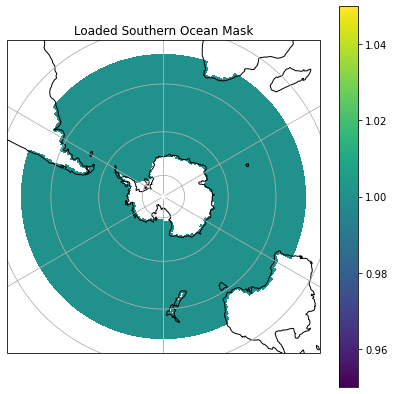

In [11]:
mapPlot(oceanMask, "Loaded Southern Ocean Mask", 1)

<br>

#### Masking ESM3 data sets
To provide a more accurate representation for mean temperature calculations the ESM3 data sets will be combined with imported ocean mask.

In [12]:
dfESMLatM = dfESMLat.where(oceanMask==1)
#dfESMLatM = dfESMLatM.reset_coords(drop=True) #Currently does not work, intended to remove variable 'volcello dimension'
print("dfESMlat masked and stored in dfESMlatM")
#dfESMLatM #Uncomment to see data set

dfESMlat masked and stored in dfESMlatM


<br>
Mask comparison

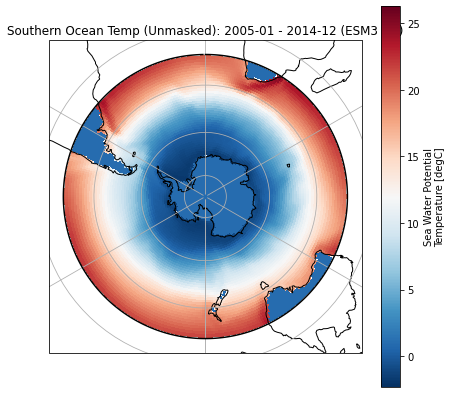

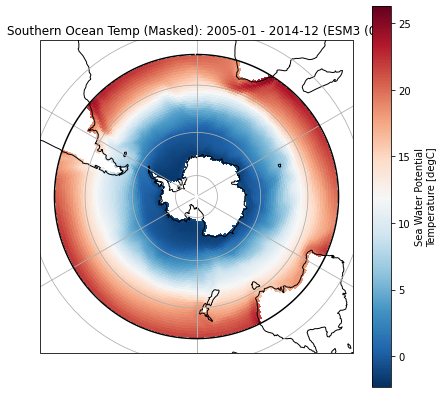

In [13]:
rangeMeanSurfaceTempESM('2005-01','2014-12', False, 0, 0) #Unmasked data set, runID = 0
rangeMeanSurfaceTempESM('2005-01','2014-12', True, 0, 1) #Masked data set, runID = 0

<br>

#### Individual Plots

Plot of ESM3 mean surface temperature data for 2005-01 to 2014-12.

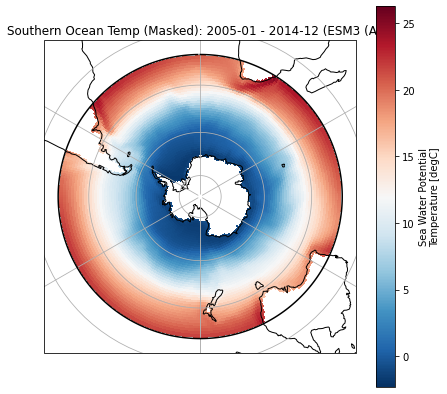

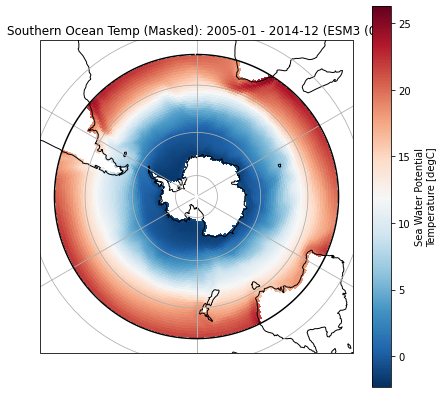

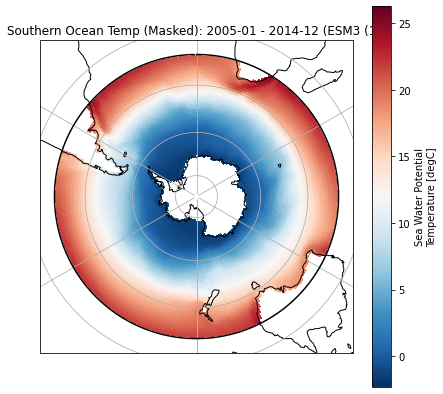

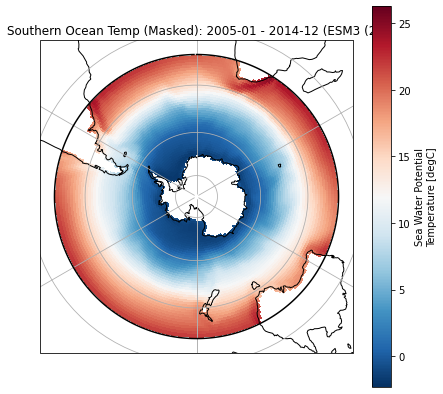

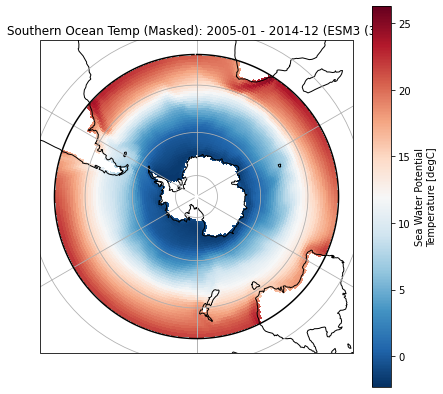

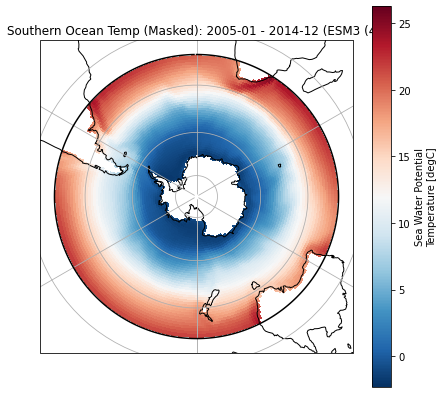

In [14]:
rangeMeanSurfaceTempESM('2005-01','2014-12', True, "All", 0)
for i in range(fileCount):
    rangeMeanSurfaceTempESM('2005-01','2014-12', True, i, i+1)

<br>
Plot of WOA surface temperature data for averaged Decade years.

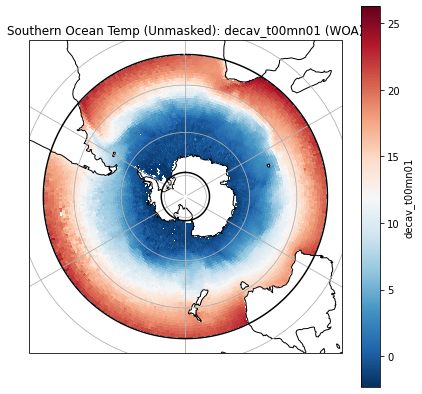

In [16]:
rangeMeanSurfaceTempWOA(dfWOALatDecav, False,1)

<br>
Plot of WOA clim mean surface temperature data for 2005 - 2017.

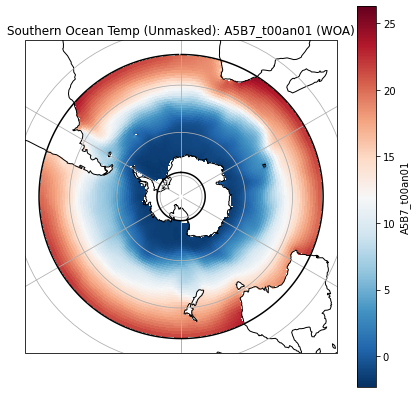

In [17]:
rangeMeanSurfaceTempWOA(dfWOALatCmean, False, 1)

<br>
Plot of WOA statistical mean surface temperature data for 2005 - 2017.

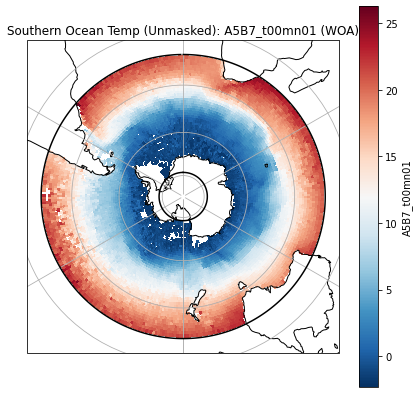

In [18]:
rangeMeanSurfaceTempWOA(dfWOALatSmean, False, 1)

<br>

#### Comparison Plots


<b>Comparing masked vs unmasked surface temperature average</b><br>
Mean surface temperature calculation for unmasked data

In [19]:
temp = dfESMLat.copy()
temp = temp.sel(lev=5.0, time=slice('2005-01', '2014-12'), RunID=0)
temp = temp.mean('time')
x = meanTemp(temp, False)
mean = x.compute()
print("Unmasked mean calculated")

Unmasked mean calculated



Mean surface temperature calculation for masked data

In [20]:
tempM = dfESMLatM.copy()
tempM = tempM.sel(lev=5.0, time=slice('2005-01', '2014-12'), RunID=0)
tempM = tempM.mean('time')
xM = meanTemp(tempM, True)
meanM = xM.compute()
print("Masked mean calculated")

Masked mean calculated



Plotting and comparison

Mean surface temp unmasked:  8.765
Mean surface temp masked:  9.964


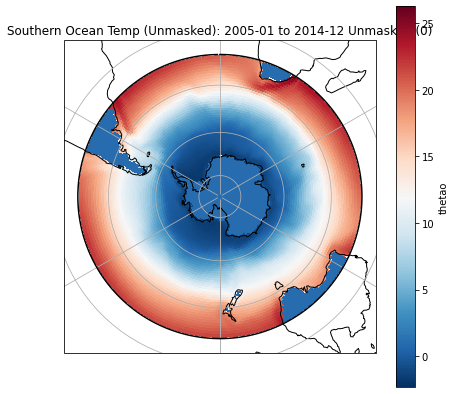

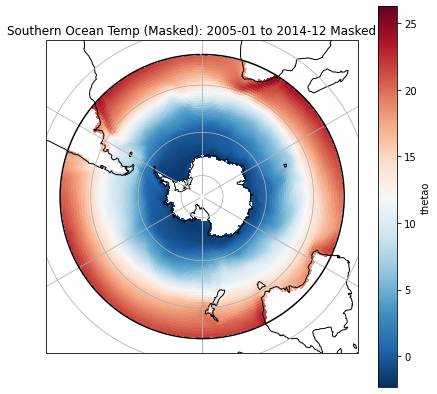

In [22]:
geoTempPlot(temp, '2005-01 to 2014-12 Unmasked', False, 0, 0)
print("Mean surface temp unmasked: ", np.round(mean.values, 3))
geoTempPlot(tempM, '2005-01 to 2014-12 Masked', True, 0, 1)
print("Mean surface temp masked: ", np.round(meanM.values[0], 3))

<br>
<b>Surface area Comparison</b>

In [23]:
surfaceAreaDifferenceMask = totalArea.values - totalAreaM.values[0]
print("Total surface area unmasked: ", f'{totalArea.values:.4}', "m^2")
print("Total surface area masked: ", f'{totalAreaM.values[0]:.4}', "m^2")
print("Surface area difference: ", f'{surfaceAreaDifferenceMask:.4}', "m^2 ("+f'{(100*surfaceAreaDifferenceMask/totalArea.values):.3}'+"%)")

Total surface area unmasked:  1.314e+14 m^2
Total surface area masked:  1.138e+14 m^2
Surface area difference:  1.757e+13 m^2 (13.4%)


<br>
Custom Surface area 

In [24]:
dataToWeight = dfESMLat.copy()
weights = np.cos(np.deg2rad(dataToWeight.lat))
weights.name = weights

In [25]:
oceanWeighted = dataToWeight.weighted(weights)
weightedMean = oceanWeighted.mean(("lon", "lat"))
weightedMean

TypeError: unhashable type: 'DataArray'